#Importación Librerías


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Proyecto Inteligencia Computacional/df_2.xlsx'
df = pd.read_excel(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tratamiento de Datos

Eliminamos las variables con mas de 150 valores nulos

In [146]:
df_copy = df.copy()
for i in df_copy:
  if df_copy[i].isna().sum() >= 150:
     df_copy = df_copy.drop(columns = [i]) 

Por lo tanto juntaremos clases las clases SNIIb, SNIIn y SNII en una sola clase puesto que tiene pocos ejemplos


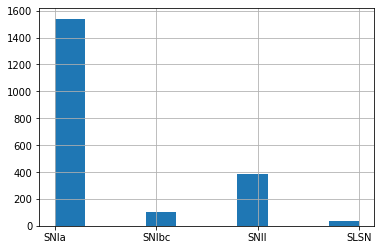

In [147]:
df_copy['classALeRCE']= df_copy['classALeRCE'].replace(['SNIIb','SNIIn'],'SNII')
df_copy['classALeRCE'].hist()
df_copy = df_copy.dropna()

Separamos el dataset en entrenamiento y testeo, ademas de balancear los datos usando SMOTE 

In [148]:
import torch.nn as nn
import torch
import time

In [149]:
torch.manual_seed(2)

In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
Le = LabelEncoder()
X = df_copy.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_copy['classALeRCE'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Ahora balanceamos los datos previamente a aplicar los modelos
from imblearn.over_sampling import SMOTE
sm= SMOTE(sampling_strategy = {'SLSN': 600 , 'SNII': 356*3, 'SNIa': 1394, 'SNIbc': 96*8})
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
X_train, y_train = X_train_smote, y_train_smote

/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (1068) in class SNII will be larger than the number of samples in the majority class (class #SNIa -> 923)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (1394) in class SNIa will be larger than the number of samples in the majority class (class #SNIa -> 923)
  warnings.warn(


In [151]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3830, 107), (3830,), (620, 107), (620,))

In [152]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

for i in range(len(y_train)):
  if y_train[i] == 'SLSN':
    y_train[i] = 0
  elif y_train[i] == 'SNII':
    y_train[i] = 1
  elif y_train[i] == 'SNIa':
    y_train[i] = 2
  elif y_train[i] == 'SNIbc':
    y_train[i] = 3

y_train = y_train.astype(np.int32)

for i in range(len(y_test)):
  if y_test[i] == 'SLSN':
    y_test[i] = 0
  elif y_test[i] == 'SNII':
    y_test[i] = 1
  elif y_test[i] == 'SNIa':
    y_test[i] = 2
  elif y_test[i] == 'SNIbc':
    y_test[i] = 3

y_test = y_test.astype(np.int32)

In [153]:
x_train = X_train.reshape(-1, X_train.shape[1]).astype('float32')
y_train = y_train

x_val = X_test.reshape(-1, X_test.shape[1]).astype('float32')
y_val = y_test

In [154]:
x_train.shape

(3830, 107)

In [155]:
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [156]:
#Pack data with labels
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_val, y_val))

In [157]:
mse_criterion = nn.MSELoss()
cross_entropy_criterion = nn.BCELoss()

In [158]:
class MLPClassifier(nn.Module):
    def __init__(self, n_features, layer_sizes):
        super().__init__()
        
        """
        Acá definimos las capas ocultas.
        Ejemplo:
        Si recibimos layer_sizes = [10, 20], entonces se creará una red:

        self.net = nn.Sequential(
            nn.Linear(n_features, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

        Las dos primeras capas (y sus respectivas funciones de activación) se
        definirán en el loop for que se tiene acá abajo. La última capa (y la
        función sigmoide final) se agrega en el append que viene luego del loop for.
        """
        
        layers = []
        prev_size = n_features
        for layer_size in layer_sizes:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size

        layers.append(nn.Linear(prev_size, 4))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [159]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [160]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    use_gpu=False
):
    if use_gpu:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": []
    }

    # Early stopping
    n_epochs_with_no_improvement = 0
    stop = False

    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i}/{len(train_loader)}", end="")
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            # Predicción
            y_predicted = model(x_batch)

            y_batch = y_batch.reshape(-1, 1).float()

            # Cálculo de loss
            loss = criterion(y_predicted, y_batch)

            # Actualización de parámetros
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

            # Calculamos número de aciertos
            class_prediction = (y_predicted > 0.5)
            cumulative_train_corrects += (y_batch == class_prediction).sum()

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects / len(train_dataset)

        # Evaluación del modelo
        model.eval()
        x_val, y_val = next(iter(val_loader))
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        y_val = y_val.reshape(-1, 1).float()
        loss = criterion(y_predicted, y_val)

        class_prediction = (y_predicted > 0.5).long()
        val_acc = (y_val == class_prediction).sum() / y_val.shape[0]
        val_loss = loss.item()

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f" - Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}")

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

In [162]:
# Entrenamiento MLP

epochs = 100
lr = 0.1
batch_size = 64
early_stopping_tolerance = 15
use_gpu = False # CAMBIAR ESTO A True SI UTILIZAN UN ENTORNO CON GPU

criterion = nn.BCELoss() # Entropía Cruzada
# criterion = nn.MSELoss() # Error Cuadrático Medio

run_n_times = 5
curves_history = []
for run in range(run_n_times):
    print(f"Entrenando corrida número {run + 1}/{run_n_times}")
    # ----- Creacion de MLP
    model = MLPClassifier(
        n_features=28 * 28,
        layer_sizes=[25],
    )

    # ----- Entrenamiento de MLP
    curves = train_model(
        model,
        train_data,
        test_data,
        max_epochs=epochs,
        criterion=criterion,
        batch_size=batch_size,
        lr=lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=use_gpu
    )

    print()

    curves_history.append(curves)

Entrenando corrida número 1/5
Epoch 1/100 - Batch 0/60

RuntimeError: ignored